In [ ]:
import sys
import os
sys.path.append(os.path.abspath("D:\\Python\\commodity_futures_price"))

import math

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# %load_ext autoreload
# %autoreload 2
%reload_ext autoreload
from model.savvy_sh import SavvySh

### Read the Files of Commodities

In [ ]:
df_dict = {}
valid_dates = pd.date_range(start="2011-01-01", end="2024-12-31", freq="B")
# Read each file in below folder
path = "../data/raw/"
files = os.listdir(path)
for file in files:
    if file.endswith(".csv"):
        # Exclude LB due to data correctness issue
        if file.startswith("LB"):
            continue
        df = pd.read_csv(os.path.join(path, file), index_col=0, parse_dates=True)
        df["Return"] = df.iloc[:, 0:1].apply(lambda x: np.log(x.shift(-1) / x))
        df = df.dropna()

        non_positive_LA = df[(df[df.columns[0]] <= 0) | (df['Volatility'] <= 0)]
        df = df.drop(index=non_positive_LA.index)

        df_dict[file[:-4]] = df
        valid_dates = valid_dates.intersection(df.index)
for name, df in df_dict.items():
    df_dict[name] = df[df.index.isin(valid_dates)]

In [ ]:
dates_len = len(valid_dates)
train_size = 3 * 12
test_size = 3

start_end_list = []
start = 0
while(start < dates_len - train_size - test_size):
    end = start + train_size + test_size - 1
    start_end_list.append((start, end))
    start = start + test_size

# print(start_end_list)

[(0, 38), (3, 41), (6, 44), (9, 47), (12, 50), (15, 53), (18, 56), (21, 59), (24, 62), (27, 65), (30, 68), (33, 71), (36, 74), (39, 77), (42, 80), (45, 83), (48, 86), (51, 89), (54, 92), (57, 95), (60, 98), (63, 101), (66, 104), (69, 107), (72, 110), (75, 113), (78, 116), (81, 119), (84, 122), (87, 125), (90, 128), (93, 131), (96, 134), (99, 137), (102, 140), (105, 143), (108, 146), (111, 149)]


### Rolling Window Prediction

In [101]:
strategies = ["OLS", "Stein", "DSh", "Sh", "SR", "GSR", "LSh", "SRR"]
mse_by_time = {strat: [] for strat in strategies}

for start, end in start_end_list:
    mse_by_df = {strat: [] for strat in strategies}
    for strat in strategies:
        for name, df in df_dict.items():
            train = df.iloc[start:end - test_size + 1]
            train_X, train_y = train.drop(columns=["Basis_Momentum", "Return"]), train["Return"]
            test_X, test_y = df.iloc[end - test_size + 1:end + 1].drop(columns=["Basis_Momentum", "Return"]), df.iloc[end - test_size + 1:end + 1]["Return"]

            scaler = StandardScaler()
            train_X = scaler.fit_transform(train_X)
            test_X = scaler.transform(test_X)

            if strat == "OLS":
                ols = LinearRegression()
                ols.fit(train_X, train_y)
                predict = ols.predict(test_X)
            elif strat == "LSh":
                model_linear = SavvySh(model_class="Linear")
                model_linear.fit(train_X, train_y)
                predict = model_linear.predict(test_X)["LSh"]
            elif strat == "SRR":
                model_shrinkage_ridge = SavvySh(model_class="ShrinkageRR")
                model_shrinkage_ridge.fit(train_X, train_y)
                predict = model_shrinkage_ridge.predict(test_X)["SRR"]
            elif strat in ["SR", "GSR"]:
                model_slab = SavvySh(model_class="Slab")
                model_slab.fit(train_X, train_y)
                tmp_pred = model_slab.predict(test_X)
                if strat == "SR":
                    predict = tmp_pred["SR"]
                else:
                    predict = tmp_pred["GSR"]
            else:
                model_mult = SavvySh(model_class="Multiplicative", include_Sh=True)
                model_mult.fit(train_X, train_y)
                tmp_pred = model_mult.predict(test_X)
                if strat == "Stein":
                    predict = tmp_pred["St"]
                elif strat == "DSh":
                    predict = tmp_pred["DSh"]
                else:
                    predict = tmp_pred["Sh"]

            mse = mean_squared_error(test_y, predict)
            mse_by_df[strat].append(mse)

        mse_by_time[strat].append(np.mean(mse_by_df[strat]))

### OLS

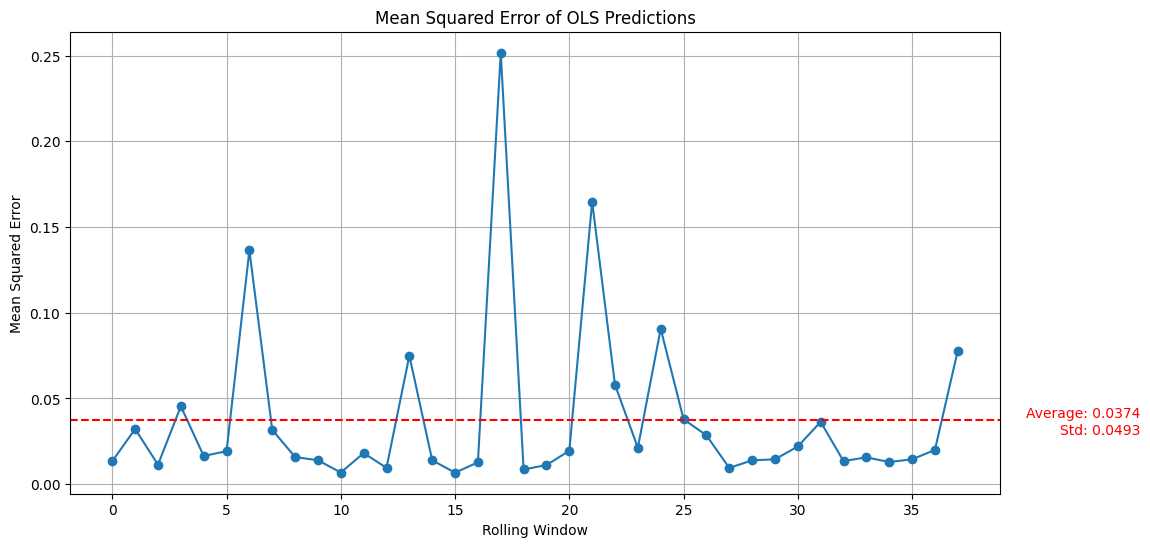

In [81]:
ols_mse_by_time = mse_by_time["OLS"]
# plot the mse
plt.figure(figsize=(12, 6))
plt.plot(ols_mse_by_time, marker='o')
plt.axhline(y=np.mean(ols_mse_by_time), color='r', linestyle='--')
plt.text(len(ols_mse_by_time) + 7, np.mean(ols_mse_by_time), f"Average: {np.mean(ols_mse_by_time):.4f}", color='r', ha='right', va='bottom')
# add std of mse
plt.text(len(ols_mse_by_time) + 7, np.mean(ols_mse_by_time) - 0.01, f"Std: {np.std(ols_mse_by_time):.4f}", color='r', ha='right', va='bottom')
plt.title("Mean Squared Error of OLS Predictions")
plt.xlabel("Rolling Window")
plt.ylabel("Mean Squared Error")
plt.grid()
plt.show()

### Stein

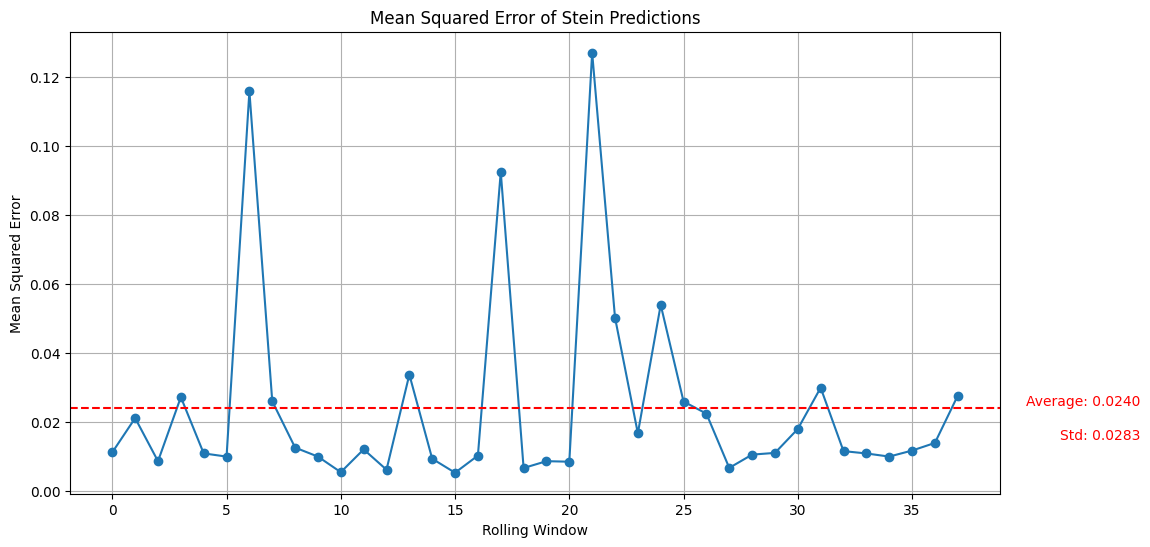

In [82]:
stein_mse_by_time = mse_by_time["Stein"]
# plot the mse
plt.figure(figsize=(12, 6))
plt.plot(stein_mse_by_time, marker='o')
plt.axhline(y=np.mean(stein_mse_by_time), color='r', linestyle='--')
plt.text(len(stein_mse_by_time) + 7, np.mean(stein_mse_by_time), f"Average: {np.mean(stein_mse_by_time):.4f}", color='r', ha='right', va='bottom')
# add std of mse
plt.text(len(stein_mse_by_time) + 7, np.mean(stein_mse_by_time) - 0.01, f"Std: {np.std(stein_mse_by_time):.4f}", color='r', ha='right', va='bottom')
plt.title("Mean Squared Error of Stein Predictions")
plt.xlabel("Rolling Window")
plt.ylabel("Mean Squared Error")
plt.grid()
plt.show()

### DSh

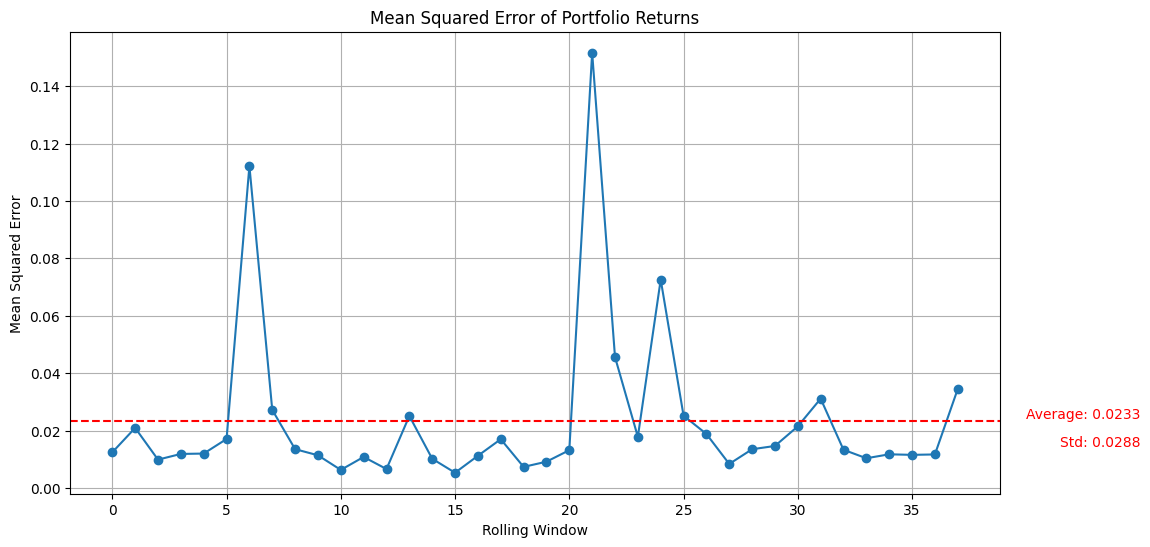

In [83]:
DSh_mse_by_time = mse_by_time["DSh"]
# plot the mse
plt.figure(figsize=(12, 6))
plt.plot(DSh_mse_by_time, marker='o')
plt.axhline(y=np.mean(DSh_mse_by_time), color='r', linestyle='--')
plt.text(len(DSh_mse_by_time) + 7, np.mean(DSh_mse_by_time), f"Average: {np.mean(DSh_mse_by_time):.4f}", color='r', ha='right', va='bottom')
# add std of mse
plt.text(len(DSh_mse_by_time) + 7, np.mean(DSh_mse_by_time) - 0.01, f"Std: {np.std(DSh_mse_by_time):.4f}", color='r', ha='right', va='bottom')
plt.title("Mean Squared Error of Portfolio Returns")
plt.xlabel("Rolling Window")
plt.ylabel("Mean Squared Error")
plt.grid()
plt.show()

### Sh

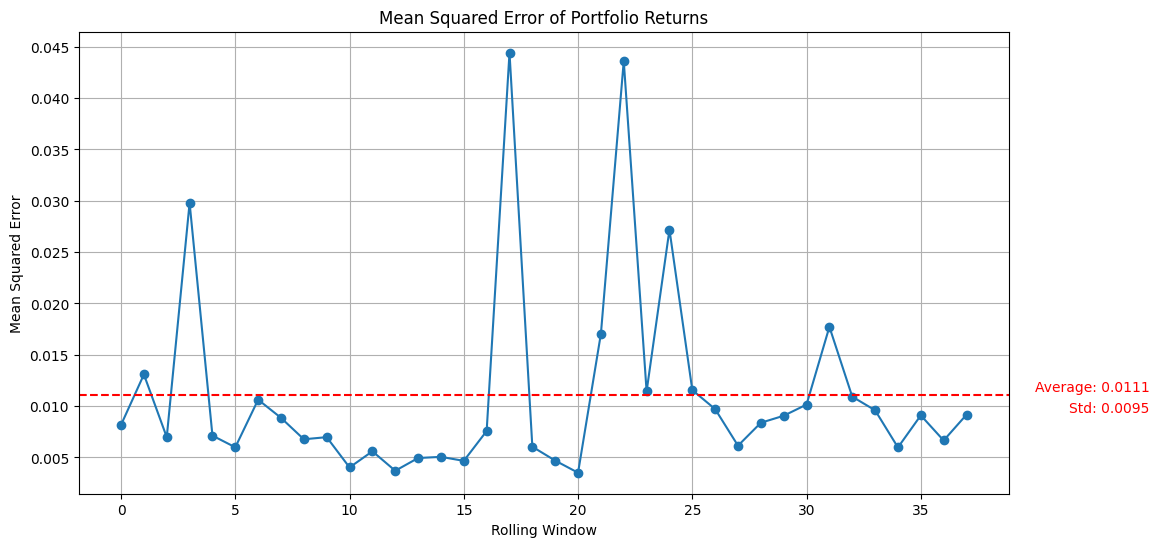

In [100]:
Sh_mse_by_time = mse_by_time["Sh"]
# plot the mse
plt.figure(figsize=(12, 6))
plt.plot(Sh_mse_by_time, marker='o')
plt.axhline(y=np.mean(Sh_mse_by_time), color='r', linestyle='--')
plt.text(len(Sh_mse_by_time) + 7, np.mean(Sh_mse_by_time), f"Average: {np.mean(Sh_mse_by_time):.4f}", color='r', ha='right', va='bottom')
# add std of mse
plt.text(len(Sh_mse_by_time) + 7, np.mean(Sh_mse_by_time) - 0.002, f"Std: {np.std(Sh_mse_by_time):.4f}", color='r', ha='right', va='bottom')
plt.title("Mean Squared Error of Portfolio Returns")
plt.xlabel("Rolling Window")
plt.ylabel("Mean Squared Error")
plt.grid()
plt.show()

### Linear Shrinakge

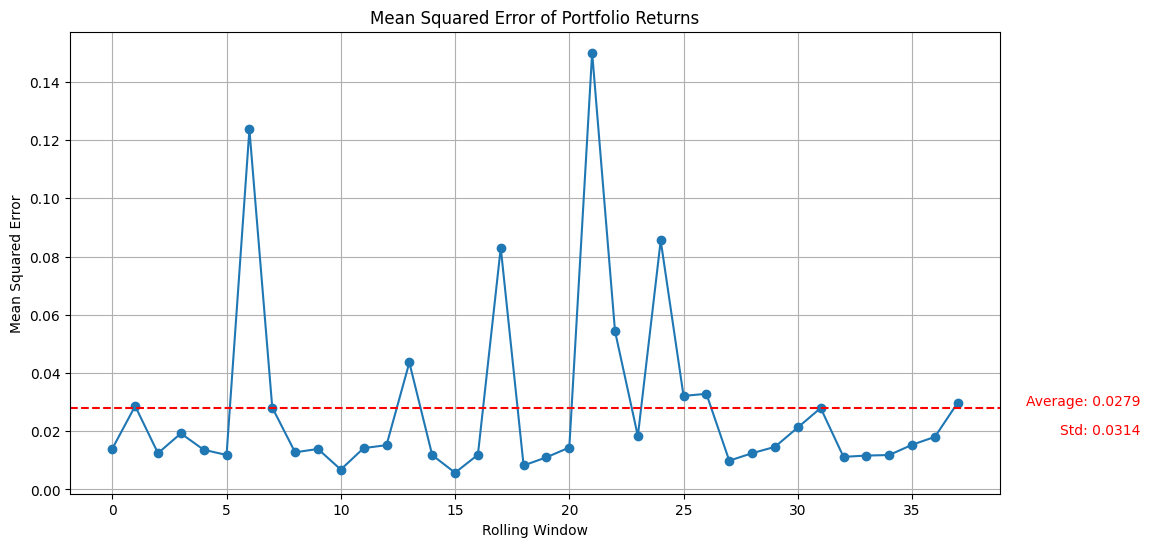

In [91]:
LSh_mse_by_time = mse_by_time["LSh"]
# plot the mse
plt.figure(figsize=(12, 6))
plt.plot(LSh_mse_by_time, marker='o')
plt.axhline(y=np.mean(LSh_mse_by_time), color='r', linestyle='--')
plt.text(len(LSh_mse_by_time) + 7, np.mean(LSh_mse_by_time), f"Average: {np.mean(LSh_mse_by_time):.4f}", color='r', ha='right', va='bottom')
# add std of mse
plt.text(len(LSh_mse_by_time) + 7, np.mean(LSh_mse_by_time) - 0.01, f"Std: {np.std(LSh_mse_by_time):.4f}", color='r', ha='right', va='bottom')
plt.title("Mean Squared Error of Portfolio Returns")
plt.xlabel("Rolling Window")
plt.ylabel("Mean Squared Error")
plt.grid()
plt.show()

### Slab

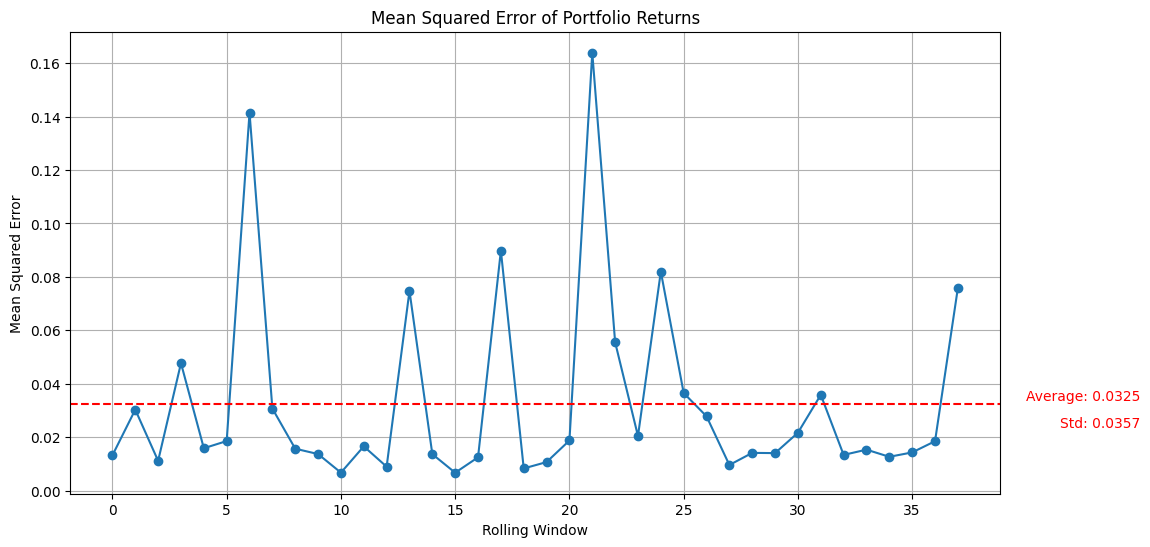

In [92]:
SR_mse_by_time = mse_by_time["SR"]
# plot the mse
plt.figure(figsize=(12, 6))
plt.plot(SR_mse_by_time, marker='o')
plt.axhline(y=np.mean(SR_mse_by_time), color='r', linestyle='--')
plt.text(len(SR_mse_by_time) + 7, np.mean(SR_mse_by_time), f"Average: {np.mean(SR_mse_by_time):.4f}", color='r', ha='right', va='bottom')
# add std of mse
plt.text(len(SR_mse_by_time) + 7, np.mean(SR_mse_by_time) - 0.01, f"Std: {np.std(SR_mse_by_time):.4f}", color='r', ha='right', va='bottom')
plt.title("Mean Squared Error of Portfolio Returns")
plt.xlabel("Rolling Window")
plt.ylabel("Mean Squared Error")
plt.grid()
plt.show()

### Generalized Slab

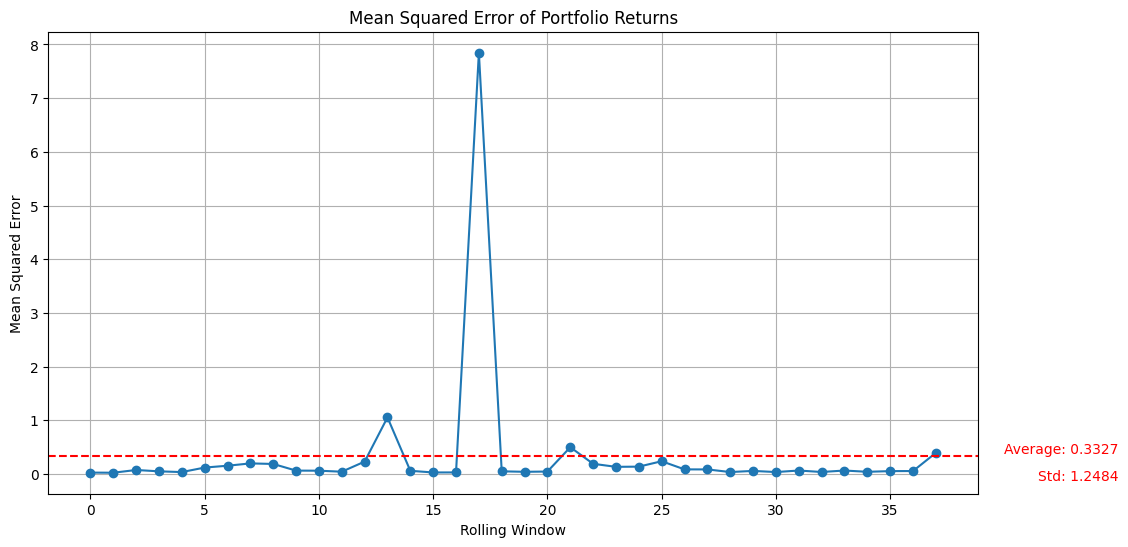

In [98]:
GSR_mse_by_time = mse_by_time["GSR"]
# plot the mse
plt.figure(figsize=(12, 6))
plt.plot(GSR_mse_by_time, marker='o')
plt.axhline(y=np.mean(GSR_mse_by_time), color='r', linestyle='--')
plt.text(len(GSR_mse_by_time) + 7, np.mean(GSR_mse_by_time), f"Average: {np.mean(GSR_mse_by_time):.4f}", color='r', ha='right', va='bottom')
# add std of mse
plt.text(len(GSR_mse_by_time) + 7, np.mean(GSR_mse_by_time) - 0.5, f"Std: {np.std(GSR_mse_by_time):.4f}", color='r', ha='right', va='bottom')
plt.title("Mean Squared Error of Portfolio Returns")
plt.xlabel("Rolling Window")
plt.ylabel("Mean Squared Error")
plt.grid()
plt.show()

### Shrinkage Ridge

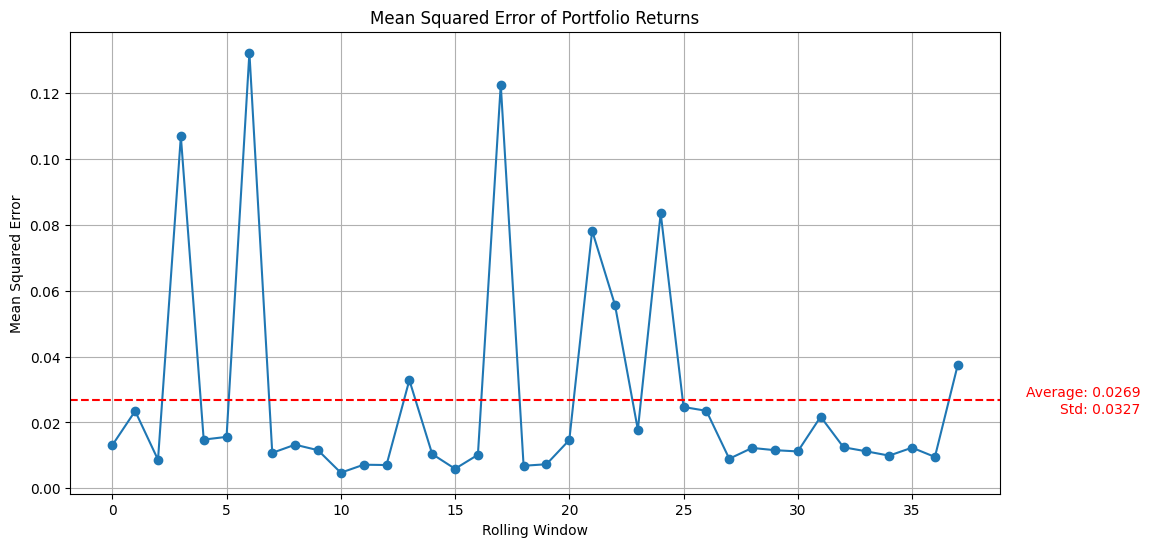

In [104]:
SRR_mse_by_time = mse_by_time["SRR"]
# plot the mse
plt.figure(figsize=(12, 6))
plt.plot(SRR_mse_by_time, marker='o')
plt.axhline(y=np.mean(SRR_mse_by_time), color='r', linestyle='--')
plt.text(len(SRR_mse_by_time) + 7, np.mean(SRR_mse_by_time), f"Average: {np.mean(SRR_mse_by_time):.4f}", color='r', ha='right', va='bottom')
# add std of mse
plt.text(len(SRR_mse_by_time) + 7, np.mean(SRR_mse_by_time) - 0.005, f"Std: {np.std(SRR_mse_by_time):.4f}", color='r', ha='right', va='bottom')
plt.title("Mean Squared Error of Portfolio Returns")
plt.xlabel("Rolling Window")
plt.ylabel("Mean Squared Error")
plt.grid()
plt.show()